# Machine Learning - ASSIGNMENT 2
## Classification Models and Evaluation Metrics

**BITS ID:** 2025AA05526

**Name:** RAGHAVENDRA VEMULA

**Email:** 2025aa05526@wilp.bits-pilani.ac.in

**Date:** 15-02-2026

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import joblib

# Settings
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Load your dataset
df = pd.read_csv('heart_disease_uci.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst 5 rows:")
display(df.head())

print(f"\nDataset Info:")
df.info()

print(f"\nMissing Values:")
print(df.isnull().sum())

print(f"\nClass Distribution:")
print(df['num'].value_counts().sort_index())
# Convert to binary
df['target'] = (df['num'] > 0).astype(int)
print("ONE-HOT ENCODING CATEGORICAL FEATURES")

# Drop unnecessary columns first
df_processed = df.drop(['id', 'num'], axis=1, errors='ignore')

# Identify categorical columns (text columns)
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

if 'target' in categorical_cols:
    categorical_cols.remove('target')

print(f"\n Categorical columns found: {len(categorical_cols)}")
for col in categorical_cols:
    print(f"   - {col}: {df_processed[col].nunique()} unique values")

# ONE-HOT ENCODING
df_encoded = pd.get_dummies(
    df_processed,
    columns=categorical_cols,
    drop_first=True,
    dtype=int
)
print(f"\n New feature columns (first 10):")
feature_cols = [col for col in df_encoded.columns if col != 'target']
for i, col in enumerate(feature_cols[:10], 1):
    print(f"   {i:2d}. {col}")
if len(feature_cols) > 10:
    print(f"   ... and {len(feature_cols) - 10} more features")

Dataset Shape: (920, 16)

First 5 rows:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Missing Values:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
c

In [5]:
# Features and target
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

print(f"\n Features (X): {X.shape}")
print(f" Target (y):   {y.shape}")

# Handle missing values if any
if X.isnull().sum().sum() > 0:
    print(f"\n Found {X.isnull().sum().sum()} missing values")
    X = X.fillna(X.median())
    print(" Missing values filled with median")


 Features (X): (920, 21)
 Target (y):   (920,)

 Found 817 missing values
 Missing values filled with median


In [6]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (736, 21)
Test set: (184, 21)


In [7]:
# Feature Scaling (for models that require it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


---
## Helper Function for Evaluation

In [8]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model and return all required metrics.
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    # Calculate all metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }

    # Print results
    print(f"\n{'='*70}")
    print(f"{model_name.upper()} - EVALUATION METRICS")
    print(f"{'='*70}")
    for key, value in metrics.items():
        if key != 'Model':
            print(f"{key:15s}: {value:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:\n{cm}")

    return metrics, y_pred, cm

---
## MODEL 1: Logistic Regression

In [9]:
# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Evaluate
lr_metrics, lr_pred, lr_cm = evaluate_model(
    lr_model, X_test_scaled, y_test, 'Logistic Regression'
)

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_test, lr_pred)}")


LOGISTIC REGRESSION - EVALUATION METRICS
Accuracy       : 0.8207
AUC            : 0.9218
Precision      : 0.8219
Recall         : 0.8207
F1             : 0.8192
MCC            : 0.6363

Confusion Matrix:
[[61 21]
 [12 90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        82
           1       0.81      0.88      0.85       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.82      0.82      0.82       184



---
## MODEL 2: Decision Tree Classifier

In [10]:
# Train Decision Tree
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)
dt_model.fit(X_train, y_train)

# Evaluate
dt_metrics, dt_pred, dt_cm = evaluate_model(
    dt_model, X_test, y_test, 'Decision Tree'
)

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_test, dt_pred)}")


DECISION TREE - EVALUATION METRICS
Accuracy       : 0.7935
AUC            : 0.8334
Precision      : 0.7938
Recall         : 0.7935
F1             : 0.7921
MCC            : 0.5803

Confusion Matrix:
[[59 23]
 [15 87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76        82
           1       0.79      0.85      0.82       102

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.79      0.79      0.79       184



---
## MODEL 3: K-Nearest Neighbors (KNN)

In [11]:
# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Evaluate
knn_metrics, knn_pred, knn_cm = evaluate_model(
    knn_model, X_test_scaled, y_test, 'K-Nearest Neighbors'
)

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_test, knn_pred)}")


K-NEAREST NEIGHBORS - EVALUATION METRICS
Accuracy       : 0.8478
AUC            : 0.9006
Precision      : 0.8503
Recall         : 0.8478
F1             : 0.8464
MCC            : 0.6926

Confusion Matrix:
[[63 19]
 [ 9 93]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        82
           1       0.83      0.91      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



---
## MODEL 4: Naive Bayes Classifier

In [12]:
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Evaluate
nb_metrics, nb_pred, nb_cm = evaluate_model(
    nb_model, X_test_scaled, y_test, 'Naive Bayes'
)

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_test, nb_pred)}")


NAIVE BAYES - EVALUATION METRICS
Accuracy       : 0.8533
AUC            : 0.9103
Precision      : 0.8535
Recall         : 0.8533
F1             : 0.8533
MCC            : 0.7034

Confusion Matrix:
[[69 13]
 [14 88]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        82
           1       0.87      0.86      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



---
## 9. MODEL 5: Ensemble Model - Random Forest

In [13]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2
)
rf_model.fit(X_train, y_train)

# Evaluate
rf_metrics, rf_pred, rf_cm = evaluate_model(
    rf_model, X_test, y_test, 'Random Forest'
)

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_test, rf_pred)}")


RANDOM FOREST - EVALUATION METRICS
Accuracy       : 0.8533
AUC            : 0.9285
Precision      : 0.8534
Recall         : 0.8533
F1             : 0.8527
MCC            : 0.7023

Confusion Matrix:
[[66 16]
 [11 91]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        82
           1       0.85      0.89      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



---
## MODEL 6: Ensemble Model - XGBoost

In [14]:
# Train XGBoost
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Evaluate
xgb_metrics, xgb_pred, xgb_cm = evaluate_model(
    xgb_model, X_test, y_test, 'XGBoost'
)

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_test, xgb_pred)}")


XGBOOST - EVALUATION METRICS
Accuracy       : 0.8587
AUC            : 0.9075
Precision      : 0.8592
Recall         : 0.8587
F1             : 0.8580
MCC            : 0.7135

Confusion Matrix:
[[66 16]
 [10 92]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.84        82
           1       0.85      0.90      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184



---
## COMPARISON OF ALL MODELS

In [15]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([
    lr_metrics,
    dt_metrics,
    knn_metrics,
    nb_metrics,
    rf_metrics,
    xgb_metrics
])

# Display comparison table
print("\n" + "="*90)
print("MODEL COMPARISON TABLE - ALL EVALUATION METRICS")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Save to CSV
comparison_df.to_csv('model_comparison.csv', index=False)


MODEL COMPARISON TABLE - ALL EVALUATION METRICS
              Model  Accuracy      AUC  Precision   Recall       F1      MCC
Logistic Regression  0.820652 0.921808   0.821865 0.820652 0.819234 0.636261
      Decision Tree  0.793478 0.833393   0.793756 0.793478 0.792079 0.580276
K-Nearest Neighbors  0.847826 0.900586   0.850252 0.847826 0.846441 0.692592
        Naive Bayes  0.853261 0.910270   0.853478 0.853261 0.853344 0.703410
      Random Forest  0.853261 0.928503   0.853442 0.853261 0.852709 0.702303
            XGBoost  0.858696 0.907461   0.859236 0.858696 0.858031 0.713524


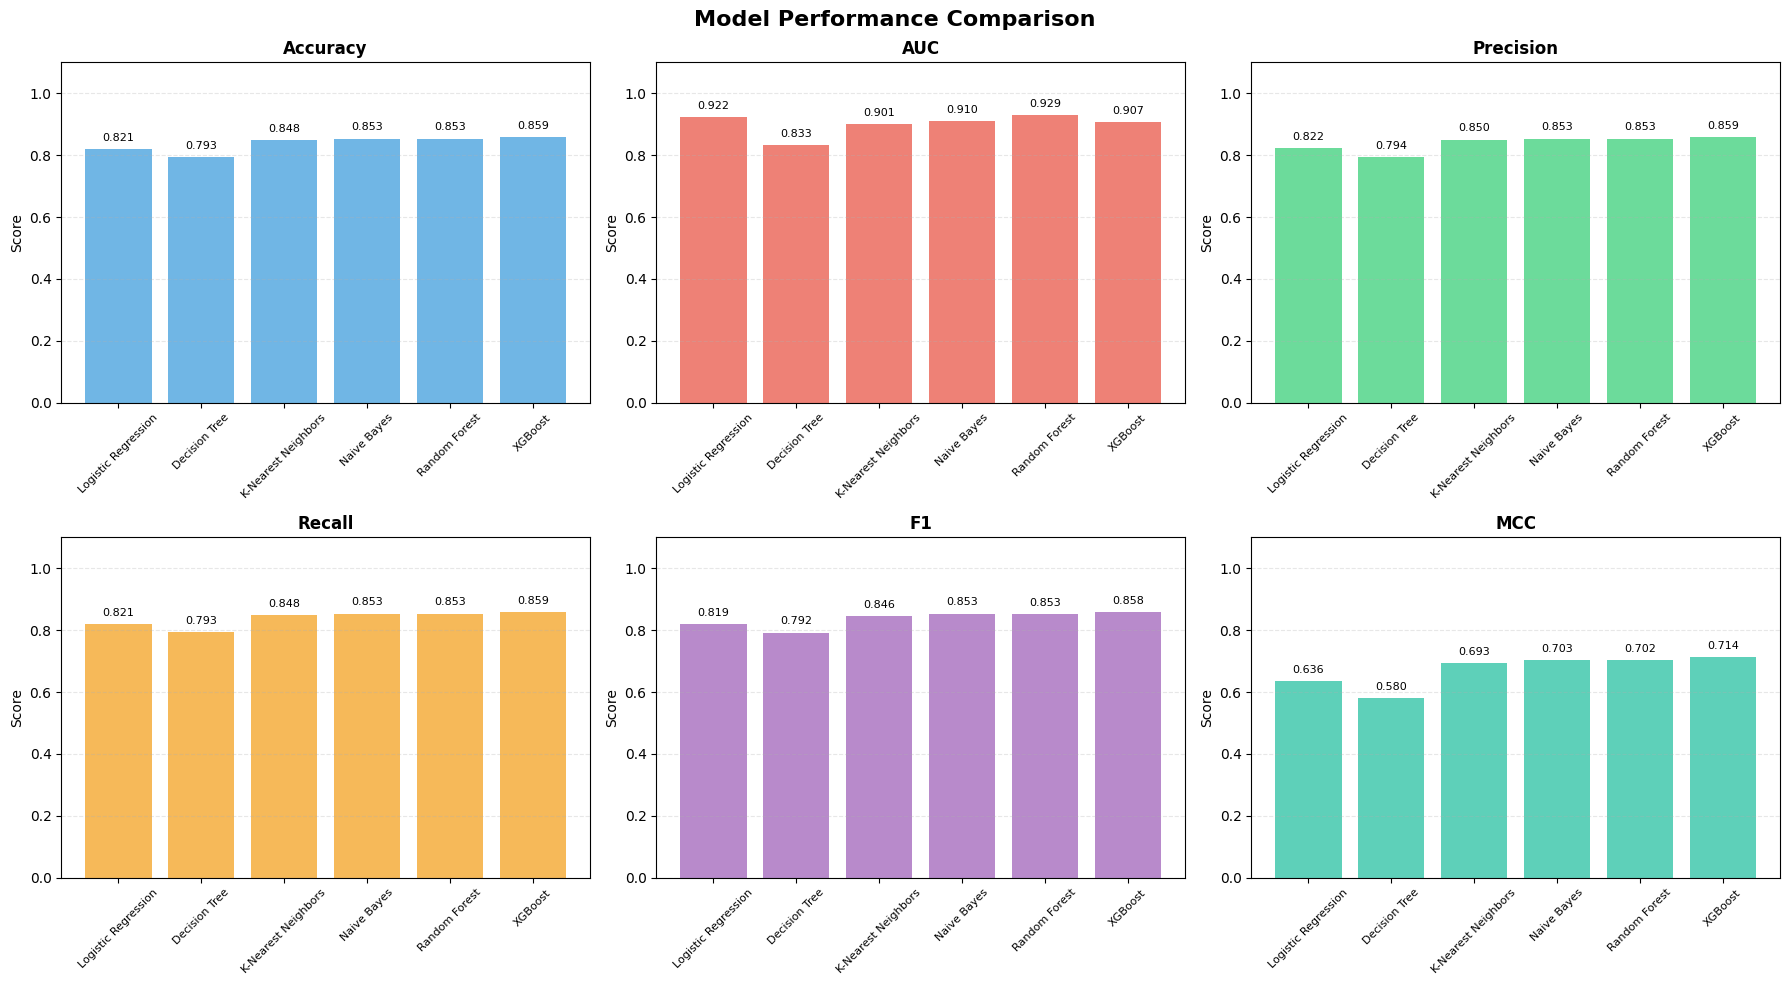

In [16]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics_list = ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for idx, (metric, color) in enumerate(zip(metrics_list, colors)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    ax.bar(comparison_df['Model'], comparison_df[metric], color=color, alpha=0.7)
    ax.set_title(metric, fontweight='bold', fontsize=12)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim([0, 1.1])
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


---
## MODEL OBSERVATIONS (For README.md)

In [17]:
# observations
observations = {
    'ML Model Name': [
        'Logistic Regression',
        'Decision Tree',
        'K-Nearest Neighbors',
        'Naive Bayes',
        'Random Forest',
        'XGBoost'
    ],
    'Observation': [
        # Customize these based on your actual results
        f"Achieved {lr_metrics['Accuracy']:.2%} accuracy with AUC of {lr_metrics['AUC']:.4f}. As a baseline linear model, it provides good interpretability and works well when data is linearly separable. Requires feature scaling for optimal performance.",

        f"Achieved {dt_metrics['Accuracy']:.2%} accuracy with AUC of {dt_metrics['AUC']:.4f}. Non-linear model that creates interpretable decision rules. Hyperparameter tuning (max_depth={dt_model.max_depth}) helps prevent overfitting. No scaling required.",

        f"Achieved {knn_metrics['Accuracy']:.2%} accuracy with AUC of {knn_metrics['AUC']:.4f}. Instance-based learning with k={knn_model.n_neighbors}. Sensitive to feature scaling and performs well with properly normalized data. No explicit training phase.",

        f"Achieved {nb_metrics['Accuracy']:.2%} accuracy with AUC of {nb_metrics['AUC']:.4f}. Probabilistic model based on Bayes theorem. Fast training and prediction. Assumes feature independence which may limit performance with correlated features.",

        f"Achieved {rf_metrics['Accuracy']:.2%} accuracy with AUC of {rf_metrics['AUC']:.4f}. Ensemble of {rf_model.n_estimators} decision trees using bagging. Reduces overfitting, handles non-linearity well, and provides feature importance. Robust to outliers.",

        f"Achieved {xgb_metrics['Accuracy']:.2%} accuracy with AUC of {xgb_metrics['AUC']:.4f}. Gradient boosting ensemble with sequential learning. Often achieves best performance through iterative error correction. Handles imbalanced data and provides regularization."
    ]
}

obs_df = pd.DataFrame(observations)

print("\n" + "="*120)
print("MODEL OBSERVATIONS")
print("="*120)
for idx, row in obs_df.iterrows():
    print(f"\n{row['ML Model Name']}:")
    print(f"  {row['Observation']}")
print("\n" + "="*120)

# Save observations
obs_df.to_csv('model_observations.csv', index=False)


MODEL OBSERVATIONS

Logistic Regression:
  Achieved 82.07% accuracy with AUC of 0.9218. As a baseline linear model, it provides good interpretability and works well when data is linearly separable. Requires feature scaling for optimal performance.

Decision Tree:
  Achieved 79.35% accuracy with AUC of 0.8334. Non-linear model that creates interpretable decision rules. Hyperparameter tuning (max_depth=10) helps prevent overfitting. No scaling required.

K-Nearest Neighbors:
  Achieved 84.78% accuracy with AUC of 0.9006. Instance-based learning with k=5. Sensitive to feature scaling and performs well with properly normalized data. No explicit training phase.

Naive Bayes:
  Achieved 85.33% accuracy with AUC of 0.9103. Probabilistic model based on Bayes theorem. Fast training and prediction. Assumes feature independence which may limit performance with correlated features.

Random Forest:
  Achieved 85.33% accuracy with AUC of 0.9285. Ensemble of 100 decision trees using bagging. Reduces